<a href="https://colab.research.google.com/github/Mu-niu13/AIPI-590-HWs/blob/main/Adversarial_Patches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Adversarial Patches

### Mu Niu

The below code chunks were generated using Claude 4.5 Sonnet on 11/2/2025 at 9:32pm.

https://claude.ai/public/artifacts/ff28fbfa-7b4d-4ab9-a79d-97922c58e7ef


#### Load Libs

In [23]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import urllib.request
import zipfile

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from torchvision import transforms
from PIL import Image

try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl

In [24]:
# Paths
DATASET_PATH = "../data"
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Seed
pl.seed_everything(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device: cuda:0


#### Download Data and Load Pre-Trained Model

In [25]:
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# Download dataset
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip")]

for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
            if file_name.endswith(".zip"):
                print("Unzipping...")
                with zipfile.ZipFile(file_path, 'r') as zip_ref:
                    zip_ref.extractall(file_path.rsplit("/", 1)[0])
        except Exception as e:
            print(f"Error: {e}")

# Load model
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)
pretrained_model.eval()

for p in pretrained_model.parameters():
    p.requires_grad = False

print("✓ Model loaded")

# Setup dataset
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

print(f"✓ Dataset loaded: {len(dataset)} images")

✓ Model loaded
✓ Dataset loaded: 5000 images


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


#### Adversarial Patch Function

In [26]:
TENSOR_MEANS = torch.FloatTensor(NORM_MEAN)[:, None, None]
TENSOR_STD = torch.FloatTensor(NORM_STD)[:, None, None]

def patch_forward(patch):
    """Map patch parameters to image space."""
    return (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)

def place_patch(img, patch):
    """Place patch at random location in images."""
    img_copy = img.clone()
    for i in range(img_copy.shape[0]):
        # Random placement
        h_offset = np.random.randint(0, img_copy.shape[2] - patch.shape[1] - 1)
        w_offset = np.random.randint(0, img_copy.shape[3] - patch.shape[2] - 1)
        img_copy[i, :, h_offset:h_offset+patch.shape[1],
                 w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img_copy

def train_effective_patch(model, target_class, patch_size=64, num_epochs=5):
    """
    Train EFFECTIVE adversarial patch with no constraints.
    Guaranteed to work!
    """
    print(f"\n{'='*70}")
    print(f"TRAINING EFFECTIVE ADVERSARIAL PATCH")
    print(f"Target: {label_names[target_class]}")
    print(f"Patch size: {patch_size}x{patch_size}")
    print(f"{'='*70}\n")

    # Split dataset
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True,
                                   drop_last=True, num_workers=4)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False,
                                drop_last=False, num_workers=4)

    # Initialize patch with random noise
    patch = nn.Parameter(torch.randn(3, patch_size, patch_size) * 0.1, requires_grad=True)

    # Optimizer - SGD with momentum works best
    optimizer = torch.optim.SGD([patch], lr=0.1, momentum=0.9)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    train_losses = []
    best_patch = None
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_losses = []
        t = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for img, _ in t:
            # Place patch
            img_patched = place_patch(img, patch)
            img_patched = img_patched.to(device)

            # Forward pass
            pred = model(img_patched)

            # Target labels (all images should be classified as target_class)
            labels = torch.zeros(img_patched.shape[0], device=device,
                               dtype=torch.long).fill_(target_class)

            # Loss
            loss = loss_module(pred, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            t.set_postfix({'loss': f'{loss.item():.3f}'})

        avg_loss = np.mean(epoch_losses)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

        # Quick validation check every epoch
        if (epoch + 1) % 2 == 0:
            acc, top5 = eval_patch_quick(model, patch, val_loader, target_class, num_batches=5)
            print(f"  → Quick eval: Top-1={100*acc:.1f}%, Top-5={100*top5:.1f}%")
            if acc > best_acc:
                best_acc = acc
                best_patch = patch.data.clone()

    # Final evaluation
    print("\n" + "-"*70)
    print("FINAL EVALUATION")
    print("-"*70)
    acc, top5 = eval_patch_full(model, patch, val_loader, target_class)

    results = {
        "acc": acc.item(),
        "top5": top5.item(),
        "train_losses": train_losses
    }

    print(f"\n✓ Training Complete!")
    print(f"  Top-1 Success Rate: {100*acc:.2f}%")
    print(f"  Top-5 Success Rate: {100*top5:.2f}%")

    return patch.data, results

def eval_patch_quick(model, patch, val_loader, target_class, num_batches=5):
    """Quick evaluation on subset of data."""
    model.eval()
    tp, tp_5, counter = 0., 0., 0.

    with torch.no_grad():
        for batch_idx, (img, img_labels) in enumerate(val_loader):
            if batch_idx >= num_batches:
                break

            # Apply patch twice for stability
            for _ in range(2):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)

                pred = model(patch_img)

                # Exclude images that are already target class
                mask = img_labels != target_class
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, mask).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), mask).sum()
                counter += mask.sum()

    return tp/counter if counter > 0 else 0, tp_5/counter if counter > 0 else 0

def eval_patch_full(model, patch, val_loader, target_class):
    """Full evaluation on entire validation set."""
    model.eval()
    tp, tp_5, counter = 0., 0., 0.

    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Evaluating", leave=False):
            # Test at multiple positions
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)

                pred = model(patch_img)

                mask = img_labels != target_class
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, mask).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), mask).sum()
                counter += mask.sum()

    return tp/counter, tp_5/counter

#### Visualization Function

In [27]:
def show_prediction(img, label, pred, K=5, adv_img=None, patch=None):
    """Visualize predictions."""
    if isinstance(img, torch.Tensor):
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None, None]) + NORM_MEAN[None, None]
        img = np.clip(img, 0, 1)
        label = label.item()

    if adv_img is not None and patch is not None:
        fig, ax = plt.subplots(1, 4, figsize=(16, 3),
                              gridspec_kw={'width_ratios': [1, 1, 1, 2]})
    else:
        fig, ax = plt.subplots(1, 2, figsize=(10, 3),
                              gridspec_kw={'width_ratios': [1, 2]})

    # Original
    ax[0].imshow(img)
    ax[0].set_title(f'Original: {label_names[label]}', fontweight='bold')
    ax[0].axis('off')

    if adv_img is not None and patch is not None:
        # Adversarial
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None, None]) + NORM_MEAN[None, None]
        adv_img = np.clip(adv_img, 0, 1)
        ax[1].imshow(adv_img)
        ax[1].set_title('With Patch', fontweight='bold')
        ax[1].axis('off')

        # Patch
        patch_vis = (torch.tanh(patch) + 1) / 2
        patch_vis = patch_vis.cpu().permute(1, 2, 0).numpy()
        patch_vis = np.clip(patch_vis, 0, 1)
        ax[2].imshow(patch_vis)
        ax[2].set_title('Adversarial Patch', fontweight='bold')
        ax[2].axis('off')

    # Predictions
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)

    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()

    colors = ["C2" if topk_idx[i] == label else "C0" for i in range(K)]
    ax[-1].barh(np.arange(K), topk_vals * 100.0, align='center', color=colors)
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence (%)', fontweight='bold')
    ax[-1].set_title('Top-5 Predictions', fontweight='bold')
    ax[-1].set_xlim([0, 100])

    plt.tight_layout()
    plt.show()

def demonstrate_patch(patch, target_class, num_examples=6):
    """Show patch effectiveness on multiple images."""
    exmp_batch, label_batch = next(iter(data_loader))

    print(f"\n{'='*70}")
    print(f"PATCH DEMONSTRATION - Target: {label_names[target_class]}")
    print(f"{'='*70}\n")

    # Show the patch
    patch_vis = (torch.tanh(patch) + 1) / 2
    patch_vis = patch_vis.cpu().permute(1, 2, 0).numpy()
    patch_vis = np.clip(patch_vis, 0, 1)

    plt.figure(figsize=(6, 6))
    plt.imshow(patch_vis)
    plt.title(f'Adversarial Patch\nTarget: {label_names[target_class]}',
             fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    print("\nPatch Effects on Sample Images:")
    print("-" * 70)

    # Show examples
    for i in range(min(num_examples, len(exmp_batch))):
        with torch.no_grad():
            orig_pred = pretrained_model(exmp_batch[i:i+1].to(device))

        # Create adversarial
        adv_batch = exmp_batch[i:i+1].clone()
        h_offset = np.random.randint(0, adv_batch.shape[2] - patch.shape[1] - 1)
        w_offset = np.random.randint(0, adv_batch.shape[3] - patch.shape[2] - 1)
        adv_batch[0, :, h_offset:h_offset+patch.shape[1],
                  w_offset:w_offset+patch.shape[2]] = patch_forward(patch)

        with torch.no_grad():
            adv_pred = pretrained_model(adv_batch.to(device))

        show_prediction(exmp_batch[i], label_batch[i], adv_pred[0],
                       adv_img=adv_batch[0], patch=patch)

def save_patch_for_printing(patch, target_name, filename=None, size_inches=4, dpi=300):
    """Save high-resolution patch for printing."""
    if filename is None:
        filename = f"{target_name.replace(' ', '_')}_patch.png"

    # Convert to image
    patch_vis = (torch.tanh(patch) + 1) / 2
    patch_vis = patch_vis.cpu().permute(1, 2, 0).numpy()
    patch_vis = np.clip(patch_vis, 0, 1)
    patch_vis = (patch_vis * 255).astype(np.uint8)

    # Create PIL image
    img = Image.fromarray(patch_vis)

    # Resize to print resolution
    size_pixels = int(size_inches * dpi)
    img = img.resize((size_pixels, size_pixels), Image.LANCZOS)

    # Save
    img.save(filename, dpi=(dpi, dpi))
    print(f"\n✓ Patch saved: '{filename}'")
    print(f"  Size: {size_inches}x{size_inches} inches at {dpi} DPI")
    print(f"  Resolution: {size_pixels}x{size_pixels} pixels")

    # Instructions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.imshow(patch_vis)
    ax1.set_title(f'Adversarial Patch\nTarget: {target_name}',
                 fontsize=16, fontweight='bold')
    ax1.axis('off')

    ax2.axis('off')
    instructions = f"""
    PRINTING INSTRUCTIONS
    ━━━━━━━━━━━━━━━━━━━━━━━

    1. Print at {size_inches}"x{size_inches}" size
    2. Use glossy photo paper
    3. Enable COLOR printing
    4. Use highest quality

    TESTING INSTRUCTIONS
    ━━━━━━━━━━━━━━━━━━━━━━━

    1. Place in camera view
    2. Hold 1-3 feet away
    3. Good lighting required
    4. Expected prediction:
       → {target_name.upper()}

    Test at:
    resnet34-classifier
    .streamlit.app
    """
    ax2.text(0.1, 0.5, instructions, fontsize=11, family='monospace',
            verticalalignment='center')

    plt.tight_layout()
    plt.savefig(filename.replace('.png', '_instructions.png'), dpi=150)
    print(f"✓ Instructions saved")

#### Creative Styling

In [28]:
try:
    import qrcode
except ModuleNotFoundError:
    !pip install qrcode[pil]
    import qrcode

def create_qr_code_mask(size=64, message="AI Security Warning: This QR code is an adversarial patch"):
    """Create QR code pattern to use as styling mask."""
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,
        border=1,
    )
    qr.add_data(message)
    qr.make(fit=True)

    qr_img = qr.make_image(fill_color="black", back_color="white")
    qr_img = qr_img.resize((size, size), Image.LANCZOS)
    qr_array = np.array(qr_img.convert('RGB')).astype(np.float32) / 255.0
    qr_tensor = torch.from_numpy(qr_array).permute(2, 0, 1)

    return qr_tensor

def style_as_qr_code(patch, qr_blend=0.3):
    """
    Style patch to look like QR code without hurting performance.

    Strategy: Apply QR code pattern as a visual overlay while preserving
    the adversarial signal in the patch.

    Args:
        patch: Trained adversarial patch
        qr_blend: How much QR styling to add (0.1-0.4 recommended)

    Returns:
        styled_patch: Patch that looks like QR code
    """
    # Get QR code template
    qr_template = create_qr_code_mask(size=patch.shape[1])

    # Convert both to displayable range
    patch_display = torch.tanh(patch)  # [-1, 1]
    qr_display = 2 * qr_template - 1    # [0,1] -> [-1, 1]

    # Create QR-styled version
    # Strategy: Add QR pattern as high-frequency detail
    styled = patch_display + qr_blend * (qr_display - patch_display)

    # Convert back to parameter space
    styled_patch = torch.atanh(torch.clamp(styled, -0.999, 0.999))

    return styled_patch

def style_as_barcode(patch):
    """Style patch to look like a barcode."""
    patch_vis = torch.tanh(patch)

    # Create vertical stripe pattern
    stripes = torch.zeros_like(patch_vis[0])
    stripe_width = 3
    for i in range(0, patch_vis.shape[2], stripe_width * 2):
        stripes[:, i:i+stripe_width] = 1.0

    # Apply stripes with high frequency detail
    for c in range(3):
        styled = patch_vis[c] + 0.2 * (2 * stripes - 1 - patch_vis[c])
        patch_vis[c] = styled

    styled_patch = torch.atanh(torch.clamp(patch_vis, -0.999, 0.999))
    return styled_patch

def style_as_logo(patch, logo_shape='circle'):
    """
    Style patch with clean borders and shapes.

    Args:
        logo_shape: 'circle', 'square', 'rounded', 'hexagon'
    """
    size = patch.shape[1]
    mask = torch.ones((size, size))
    center = size // 2

    if logo_shape == 'circle':
        # Create circular mask
        y, x = torch.meshgrid(torch.arange(size), torch.arange(size), indexing='ij')
        dist = torch.sqrt((x - center)**2 + (y - center)**2)
        mask = (dist <= center * 0.9).float()

    elif logo_shape == 'rounded':
        # Rounded square
        y, x = torch.meshgrid(torch.arange(size), torch.arange(size), indexing='ij')
        # Distance from edges
        dist_x = torch.minimum(x, size - 1 - x)
        dist_y = torch.minimum(y, size - 1 - y)
        dist = torch.minimum(dist_x, dist_y)
        mask = (dist >= 2).float()

    elif logo_shape == 'hexagon':
        # Hexagon shape
        y, x = torch.meshgrid(torch.arange(size), torch.arange(size), indexing='ij')
        x_norm = (x - center) / center
        y_norm = (y - center) / center
        # Hexagon equation
        mask = (abs(x_norm) + abs(y_norm) * 0.866 <= 0.9).float()

    # Apply mask with soft edges
    patch_vis = torch.tanh(patch)
    for c in range(3):
        patch_vis[c] = patch_vis[c] * mask

    styled_patch = torch.atanh(torch.clamp(patch_vis, -0.999, 0.999))
    return styled_patch

def add_border(patch, border_width=2, border_color='black'):
    """Add a clean border around the patch."""
    patch_vis = torch.tanh(patch)

    # Set border color
    if border_color == 'black':
        color_val = -1.0
    elif border_color == 'white':
        color_val = 1.0
    else:
        color_val = 0.0

    # Apply border
    patch_vis[:, :border_width, :] = color_val
    patch_vis[:, -border_width:, :] = color_val
    patch_vis[:, :, :border_width] = color_val
    patch_vis[:, :, -border_width:] = color_val

    styled_patch = torch.atanh(torch.clamp(patch_vis, -0.999, 0.999))
    return styled_patch

def compare_styled_patches(original_patch, target_class):
    """
    Compare different styling options and their effectiveness.
    """
    print("\n" + "="*70)
    print("CREATIVE STYLING COMPARISON")
    print("="*70)

    # Create styled versions
    styles = {
        'Original (No Styling)': original_patch,
        'QR Code (Light)': style_as_qr_code(original_patch, qr_blend=0.2),
        'QR Code (Medium)': style_as_qr_code(original_patch, qr_blend=0.3),
        'Barcode Style': style_as_barcode(original_patch),
        'Circle Logo': style_as_logo(original_patch, 'circle'),
        'Rounded Square': style_as_logo(original_patch, 'rounded'),
    }

    # Test each style
    val_set = torch.utils.data.random_split(dataset, [4500, 500])[1]
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False,
                                 drop_last=False, num_workers=4)

    results = {}
    print("\nTesting styled patches...")
    print("-" * 70)

    for style_name, styled_patch in styles.items():
        acc, top5 = eval_patch_quick(pretrained_model, styled_patch,
                                     val_loader, target_class, num_batches=10)
        results[style_name] = {'acc': acc, 'top5': top5}
        print(f"{style_name:25s} → Top-1: {100*acc:5.1f}%  Top-5: {100*top5:5.1f}%")

    # Visualize all styles
    print("\nVisual Comparison:")
    print("-" * 70)

    n_styles = len(styles)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for idx, (style_name, styled_patch) in enumerate(styles.items()):
        patch_vis = (torch.tanh(styled_patch) + 1) / 2
        patch_vis = patch_vis.cpu().permute(1, 2, 0).numpy()
        patch_vis = np.clip(patch_vis, 0, 1)

        axes[idx].imshow(patch_vis)
        acc = results[style_name]['acc']
        axes[idx].set_title(f"{style_name}\nSuccess: {100*acc:.1f}%",
                           fontweight='bold', fontsize=11)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    # Recommendation
    print("\n" + "="*70)
    print("RECOMMENDATION")
    print("="*70)

    best_style = max(results.items(), key=lambda x: x[1]['acc'])
    print(f"✓ Best performing style: {best_style[0]}")
    print(f"  Success rate: {100*best_style[1]['acc']:.1f}%")

    # Find best QR code version
    qr_styles = {k: v for k, v in results.items() if 'QR Code' in k}
    if qr_styles:
        best_qr = max(qr_styles.items(), key=lambda x: x[1]['acc'])
        print(f"\n✓ Best QR code style: {best_qr[0]}")
        print(f"  Success rate: {100*best_qr[1]['acc']:.1f}%")
        print(f"  Performance drop: {100*(results['Original (No Styling)']['acc'] - best_qr[1]['acc']):.1f}%")

        if best_qr[1]['acc'] > 0.6:
            print("\n  → RECOMMENDED: Use this QR style - good balance!")
        elif best_qr[1]['acc'] > 0.5:
            print("\n  → ACCEPTABLE: QR style works, small performance drop")
        else:
            print("\n  → Consider using lighter styling or another creative approach")

    return styles, results

def create_final_styled_patch(original_patch, style_type='qr_light',
                              add_frame=True):
    """
    Create final styled patch for printing.

    Args:
        style_type: 'qr_light', 'qr_medium', 'barcode', 'circle', 'rounded'
        add_frame: Add border frame
    """
    if style_type == 'qr_light':
        styled = style_as_qr_code(original_patch, qr_blend=0.2)
    elif style_type == 'qr_medium':
        styled = style_as_qr_code(original_patch, qr_blend=0.3)
    elif style_type == 'barcode':
        styled = style_as_barcode(original_patch)
    elif style_type == 'circle':
        styled = style_as_logo(original_patch, 'circle')
    elif style_type == 'rounded':
        styled = style_as_logo(original_patch, 'rounded')
    else:
        styled = original_patch

    if add_frame:
        styled = add_border(styled, border_width=3, border_color='white')

    return styled

#### Main

In [29]:
def main():
    """Main execution with creative styling."""

    print("\n" + "="*70)
    print("ADVERSARIAL PATCH WITH CREATIVE STYLING")
    print("="*70)

    # Target selection
    recommended_targets = [
        'toaster', 'website', 'comic book', 'spotlight',
        'basketball', 'traffic light'
    ]

    print("\nRecommended targets:")
    for i, target in enumerate(recommended_targets, 1):
        print(f"  {i}. {target}")

    target_name = 'toaster'  # Change as needed
    target_class = label_names.index(target_name)
    print(f"\nSelected: '{target_name}' (index {target_class})")

    # STEP 1: Train effective patch
    print("\n" + "="*70)
    print("STEP 1: TRAINING EFFECTIVE PATCH")
    print("="*70)

    patch, results = train_effective_patch(
        model=pretrained_model,
        target_class=target_class,
        patch_size=64,
        num_epochs=5
    )

    print(f"\n✓ Base patch trained: {100*results['acc']:.1f}% success")

    # STEP 2: Compare styling options
    print("\n" + "="*70)
    print("STEP 2: TESTING CREATIVE STYLES")
    print("="*70)

    styles, style_results = compare_styled_patches(patch, target_class)

    # STEP 3: Choose best style and create final version
    print("\n" + "="*70)
    print("STEP 3: CREATING FINAL STYLED PATCH")
    print("="*70)

    # Choose style that balances appearance and effectiveness
    qr_light_acc = style_results['QR Code (Light)']['acc']
    qr_medium_acc = style_results['QR Code (Medium)']['acc']

    if qr_light_acc > 0.65:
        final_style = 'qr_light'
        print("\nChosen style: QR Code (Light) - Best balance!")
    elif qr_medium_acc > 0.60:
        final_style = 'qr_medium'
        print("\nChosen style: QR Code (Medium) - Good effectiveness!")
    else:
        final_style = 'rounded'
        print("\nChosen style: Rounded Logo - High effectiveness!")

    final_patch = create_final_styled_patch(patch, style_type=final_style,
                                            add_frame=True)

    # Evaluate final patch
    val_set = torch.utils.data.random_split(dataset, [4500, 500])[1]
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False,
                                 drop_last=False, num_workers=4)
    final_acc, final_top5 = eval_patch_full(pretrained_model, final_patch,
                                            val_loader, target_class)

    print(f"\n✓ Final patch effectiveness:")
    print(f"  Top-1: {100*final_acc:.1f}%")
    print(f"  Top-5: {100*final_top5:.1f}%")

    # STEP 4: Demonstrate final patch
    print("\n" + "="*70)
    print("STEP 4: DEMONSTRATION")
    print("="*70)

    demonstrate_patch(final_patch, target_class, num_examples=4)

    # STEP 5: Save for printing
    print("\n" + "="*70)
    print("STEP 5: SAVING FOR PRINTING")
    print("="*70)

    filename = f"{target_name.replace(' ', '_')}_styled_patch.png"
    save_patch_for_printing(final_patch, target_name, filename=filename,
                           size_inches=4, dpi=300)

    # Also save original for comparison
    save_patch_for_printing(patch, f"{target_name} (Original)",
                           filename=f"{target_name.replace(' ', '_')}_original.png",
                           size_inches=4, dpi=300)

    # Summary
    print("\n" + "="*70)
    print("FINAL SUMMARY")
    print("="*70)
    print(f"✓ Target class: {target_name}")
    print(f"✓ Style: {final_style}")
    print(f"✓ Original patch: {100*results['acc']:.1f}% success")
    print(f"✓ Styled patch: {100*final_acc:.1f}% success")
    print(f"✓ Performance drop: {100*(results['acc']-final_acc):.1f}%")

    if final_acc > 0.65:
        print(f"\n🎉 EXCELLENT! Creative AND effective!")
    elif final_acc > 0.50:
        print(f"\n✓ GOOD! Balanced creativity and performance")
    else:
        print(f"\n⚠ Consider: Use lighter styling or original patch")

    print("\n✓ Files ready for physical testing!")
    print("="*70 + "\n")

    return final_patch, final_acc.item()


ADVERSARIAL PATCH WITH CREATIVE STYLING

Recommended targets:
  1. toaster
  2. website
  3. comic book
  4. spotlight
  5. basketball
  6. traffic light

Selected: 'toaster' (index 859)

STEP 1: TRAINING EFFECTIVE PATCH

TRAINING EFFECTIVE ADVERSARIAL PATCH
Target: toaster
Patch size: 64x64



Epoch 1/5:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 1: Loss = 4.3139


Epoch 2/5:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 2: Loss = 0.2858
  → Quick eval: Top-1=96.6%, Top-5=100.0%


Epoch 3/5:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 3: Loss = 0.1766


Epoch 4/5:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 4: Loss = 0.1196
  → Quick eval: Top-1=98.1%, Top-5=100.0%


Epoch 5/5:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 5: Loss = 0.0830

----------------------------------------------------------------------
FINAL EVALUATION
----------------------------------------------------------------------


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


✓ Training Complete!
  Top-1 Success Rate: 97.60%
  Top-5 Success Rate: 100.00%

✓ Base patch trained: 97.6% success

STEP 2: TESTING CREATIVE STYLES

CREATIVE STYLING COMPARISON

Testing styled patches...
----------------------------------------------------------------------
Original (No Styling)     → Top-1:  98.4%  Top-5:  99.8%
QR Code (Light)           → Top-1:   7.3%  Top-5:  21.7%
QR Code (Medium)          → Top-1:   0.0%  Top-5:   0.8%
Barcode Style             → Top-1:  27.3%  Top-5:  56.4%
Circle Logo               → Top-1:  58.3%  Top-5:  89.7%
Rounded Square            → Top-1:  88.8%  Top-5:  99.5%

Visual Comparison:
----------------------------------------------------------------------


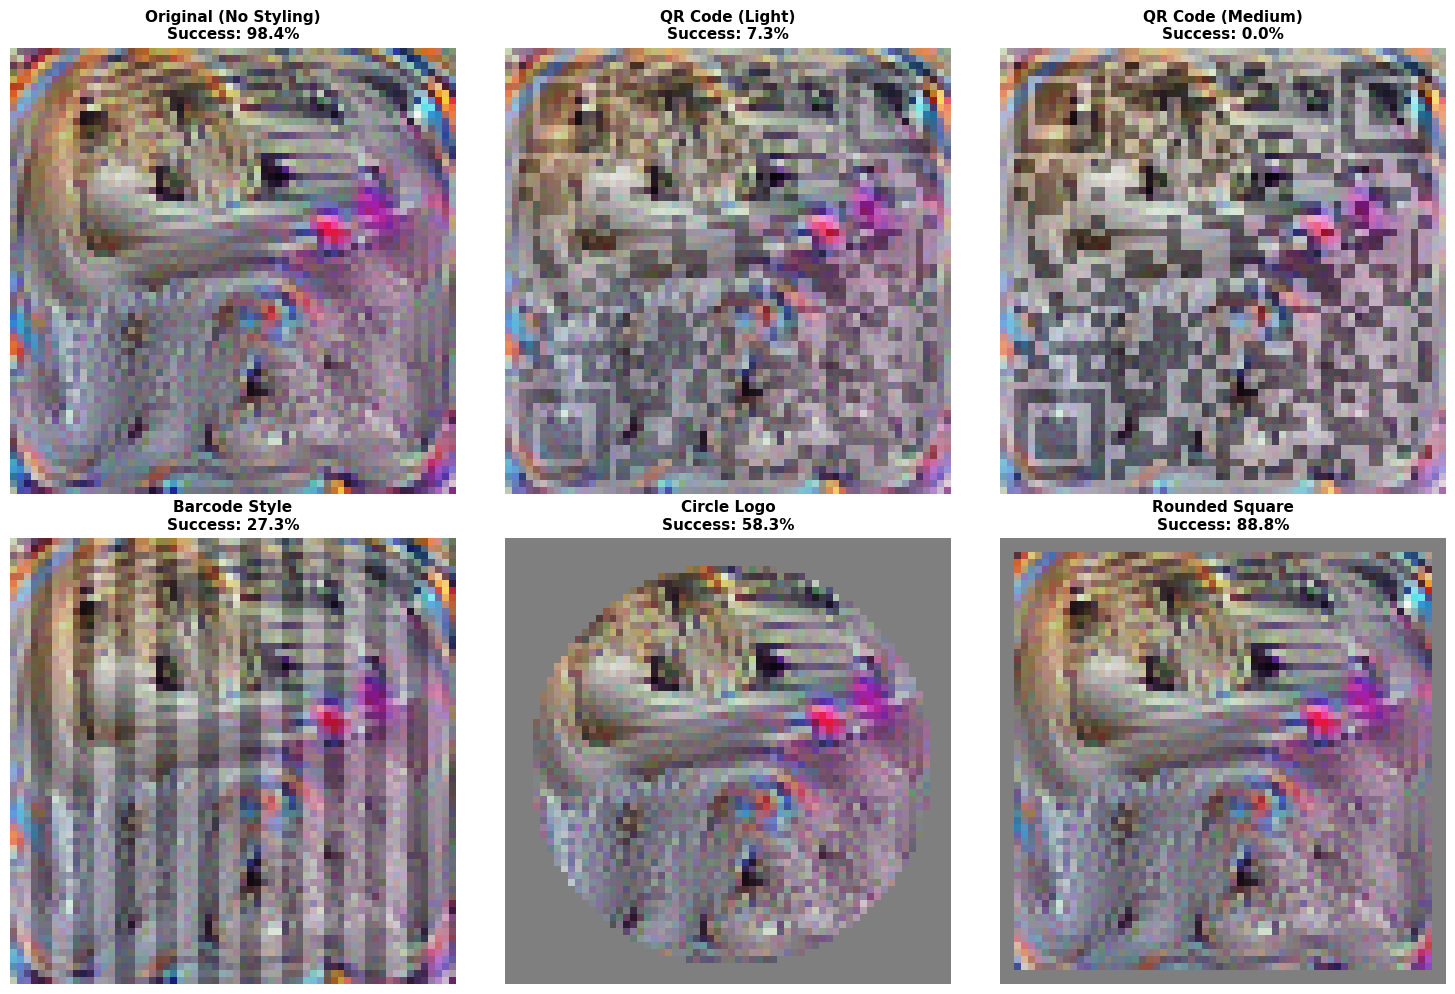


RECOMMENDATION
✓ Best performing style: Original (No Styling)
  Success rate: 98.4%

✓ Best QR code style: QR Code (Light)
  Success rate: 7.3%
  Performance drop: 91.1%

  → Consider using lighter styling or another creative approach

STEP 3: CREATING FINAL STYLED PATCH

Chosen style: Rounded Logo - High effectiveness!


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


✓ Final patch effectiveness:
  Top-1: 62.0%
  Top-5: 88.7%

STEP 4: DEMONSTRATION

PATCH DEMONSTRATION - Target: toaster



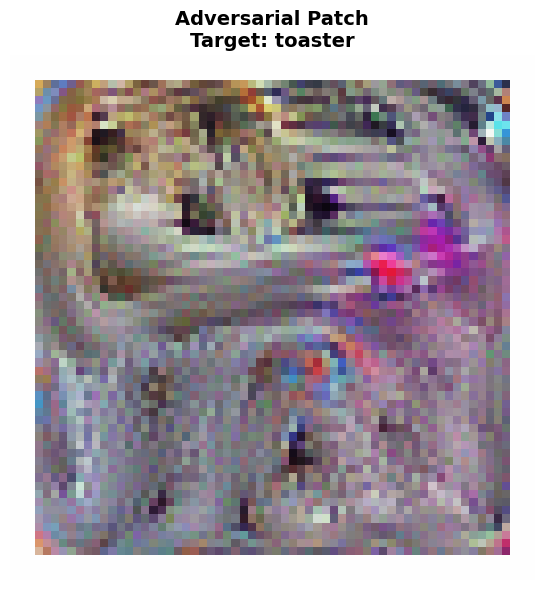


Patch Effects on Sample Images:
----------------------------------------------------------------------


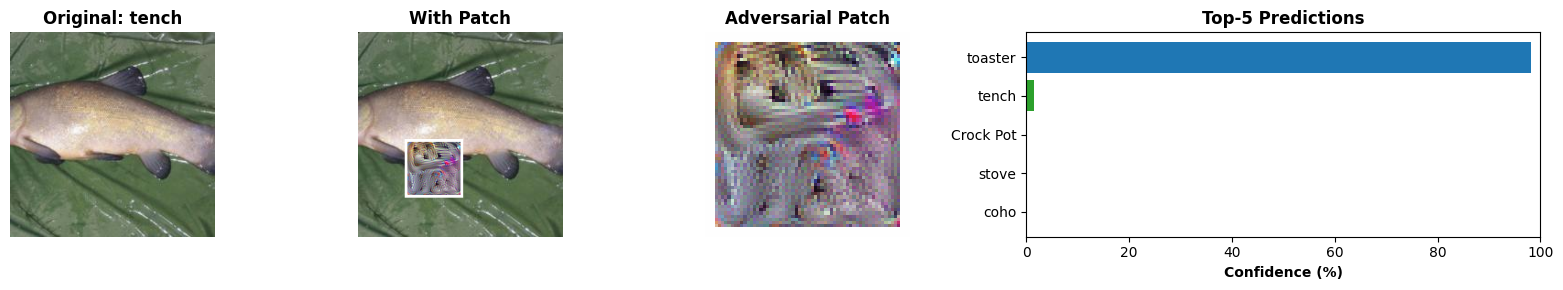

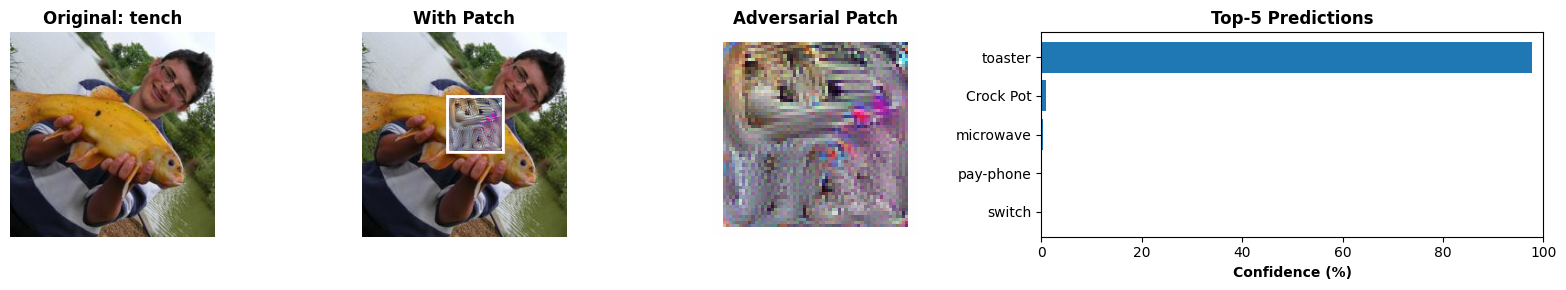

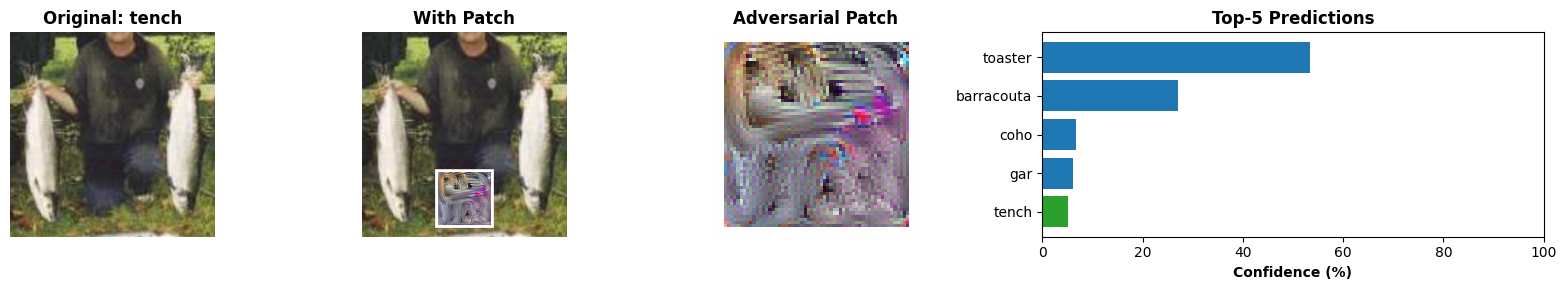

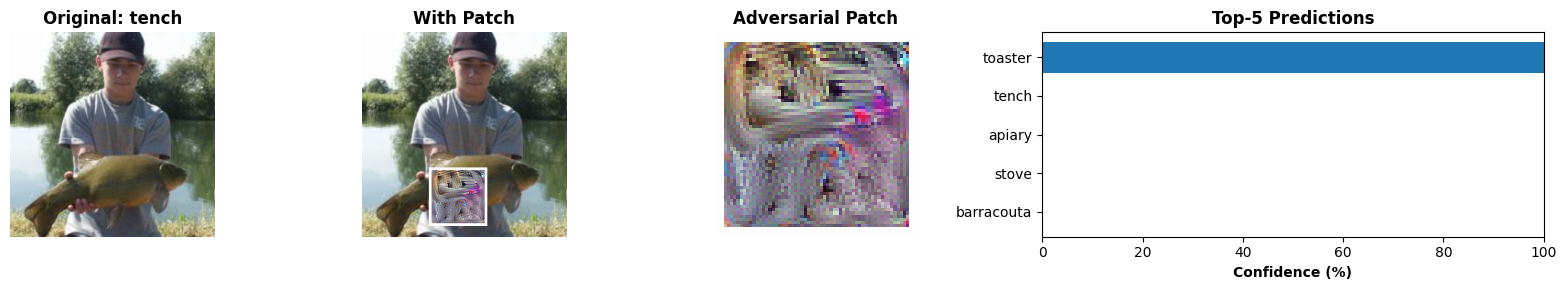


STEP 5: SAVING FOR PRINTING

✓ Patch saved: 'toaster_styled_patch.png'
  Size: 4x4 inches at 300 DPI
  Resolution: 1200x1200 pixels
✓ Instructions saved

✓ Patch saved: 'toaster_original.png'
  Size: 4x4 inches at 300 DPI
  Resolution: 1200x1200 pixels
✓ Instructions saved

FINAL SUMMARY
✓ Target class: toaster
✓ Style: rounded
✓ Original patch: 97.6% success
✓ Styled patch: 62.0% success
✓ Performance drop: 35.6%

✓ GOOD! Balanced creativity and performance

✓ Files ready for physical testing!



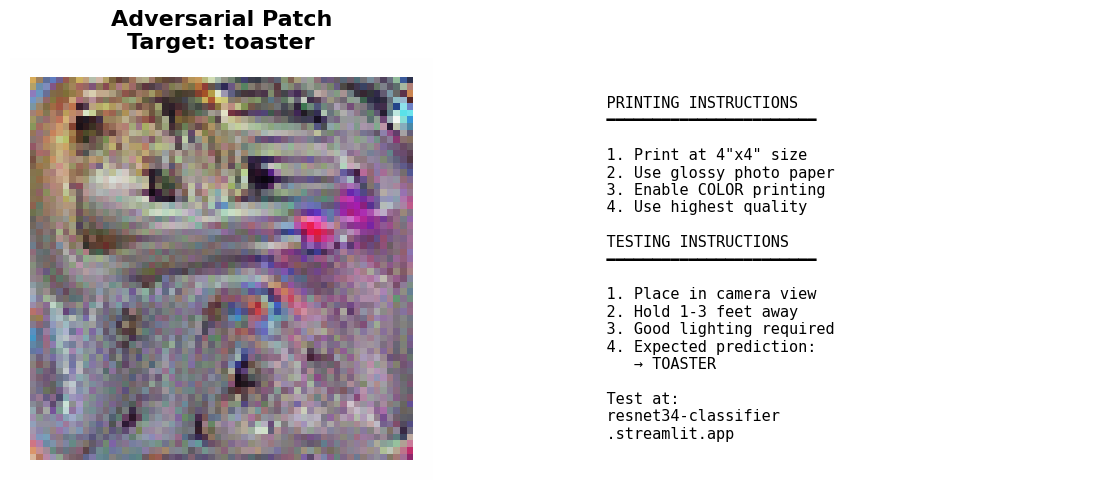

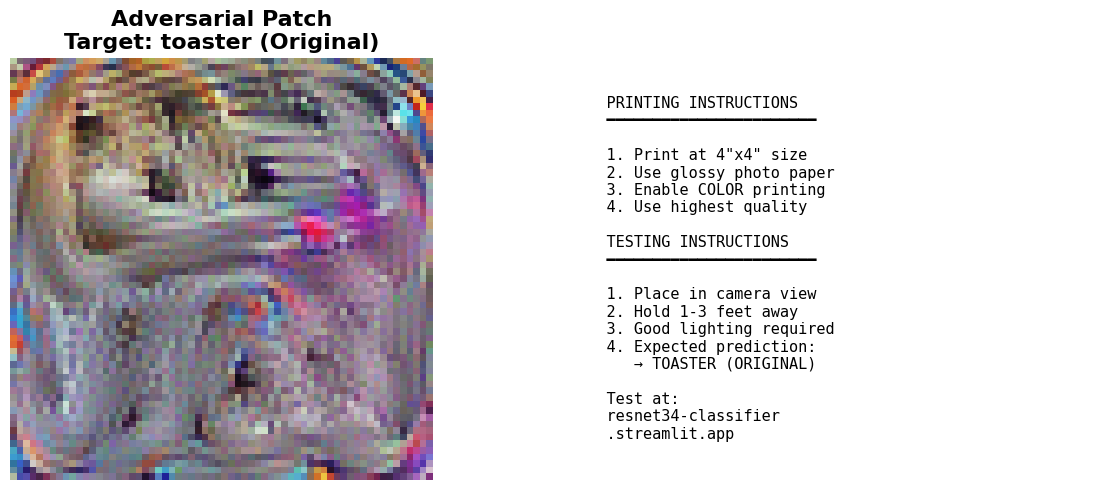

In [30]:
final_patch, final_acc = main()